In [1]:
# ********************************************************************************
# IMPORTANT: BEFORE RUNNING THIS CELL, PERFORM A "FACTORY RESET RUNTIME" (Colab)
# OR THE EQUIVALENT DEEPEST RESTART IN YOUR ENVIRONMENT (e.g., Kaggle Session Restart).
# THEN, RUN THIS CELL AS THE VERY FIRST CODE IN YOUR NOTEBOOK.
# ********************************************************************************
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.12.3 xgboost==2.0.3
import pandas as pd
import numpy as np
import os
from collections import Counter
import ast
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
import json
import gc

try:
    from imblearn.over_sampling import SMOTE
    print("\nSuccessfully imported SMOTE.")
except ImportError as e:
    print(f"\nCRITICAL ERROR: Failed to import SMOTE: {e}")
    print("Please double-check that you performed a 'Factory reset runtime' (Colab) or equivalent.")
    exit()

# Label mappings for numeric labels in GeoJSON files
genus_mapping = {
    '0': 'beech',
    '1': 'douglas fir',
    '2': 'fir',
    '3': 'larch',
    '4': 'long-lived deciduous',
    '5': 'oak',
    '6': 'pine',
    '7': 'short-lived deciduous',
    '8': 'spruce'
}

species_mapping = {
    '0': 'alder',
    '1': 'birch',
    '2': 'black pine',
    '3': 'cherry',
    '4': 'douglas fir',
    '5': 'english oak',
    '6': 'european beech',
    '7': 'european ash',
    '8': 'european larch',
    '9': 'japanese larch',
    '10': 'linden',
    '11': 'norway spruce',
    '12': 'poplar',
    '13': 'red oak',
    '14': 'scots pine',
    '15': 'sessile oak',
    '16': 'silver fir',
    '17': 'sycamore maple',
    '18': 'weymouth pine'
}

# 1. Inspect and Load GeoJSON Files
data_dir = "/kaggle/input/mar-oct"  # Replace with your folder path
all_features = []
all_l1_labels = []  # Leaf types
all_l2_labels = []  # Genus
all_l3_labels = []  # Species
invalid_samples = []
invalid_bands = Counter()
species_counts = Counter()
genus_counts = Counter()
leaf_counts = Counter()

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'SAVI', 'NDWI', 'DEM']
months = ['', '_1', '_2', '_3', '_4', '_5', '_6', '_7']
band_columns = [band + month for month in months for band in bands]

# Inspect first file
first_file = os.path.join(data_dir, os.listdir(data_dir)[0]) if os.listdir(data_dir) else None
if first_file and first_file.endswith(".geojson"):
    gdf = gpd.read_file(first_file)
    print("Inspecting first 2 rows of first GeoJSON file:")
    print(f"Available columns: {list(gdf.columns)}")
    
    required_cols = ['l1_leaf_types', 'l2_genus', 'l3_species']
    available_cols = [col for col in required_cols if col in gdf.columns]
    missing_cols = [col for col in required_cols if col not in gdf.columns]
    
    print(f"Available hierarchical labels: {available_cols}")
    if missing_cols:
        print(f"WARNING: Missing hierarchical labels: {missing_cols}")
        print("The hierarchical model requires all three levels (l1_leaf_types, l2_genus, l3_species)")
    
    for idx in range(min(2, len(gdf))):
        print(f"\nRow {idx}:")
        for label_col in ['l1_leaf_types', 'l2_genus', 'l3_species']:
            if label_col in gdf.columns:
                raw_label = gdf[label_col].iloc[idx]
                if label_col == 'l2_genus' and str(raw_label) in genus_mapping:
                    mapped_label = genus_mapping[str(raw_label)]
                    print(f"  {label_col}: {raw_label} (mapped to {mapped_label})")
                elif label_col == 'l3_species' and str(raw_label) in species_mapping:
                    mapped_label = species_mapping[str(raw_label)]
                    print(f"  {label_col}: {raw_label} (mapped to {mapped_label})")
                else:
                    print(f"  {label_col}: {raw_label}")
        
        for band in ['B1', 'B2', 'B11', 'NDVI', 'DEM', 'B2_1', 'NDVI_7']:
            if band in gdf.columns:
                data = gdf[band].iloc[idx]
                try:
                    parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                    array = np.array(parsed_data, dtype=np.float32)
                    print(f"  Band {band}: shape={array.shape}, first few values={array.flatten()[:5]}")
                except (ValueError, SyntaxError, TypeError) as e:
                    print(f"  Band {band}: Error parsing/converting: {e}")
            else:
                print(f"  Band {band}: Not found in GeoJSON file")

# Load all GeoJSON files
total_samples_attempted = 0
hierarchical_labels_available = True

for file in os.listdir(data_dir):
    if file.endswith(".geojson"):
        try:
            gdf = gpd.read_file(os.path.join(data_dir, file))
            print(f"Processing file: {file}, Rows: {len(gdf)}")
            print(f"Sample l2_genus values: {gdf['l2_genus'].head().tolist()}")
            print(f"Sample l3_species values: {gdf['l3_species'].head().tolist()}")
            total_samples_attempted += len(gdf)
            
            if not all(col in gdf.columns for col in ['l1_leaf_types', 'l2_genus', 'l3_species']):
                print(f"WARNING: File {file} is missing hierarchical labels")
                hierarchical_labels_available = False
            
            for idx, row in gdf.iterrows():
                try:
                    patch = []
                    for col in band_columns:
                        if col not in gdf.columns:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        data = row[col]
                        if data is None or (isinstance(data, str) and data.lower() == 'none'):
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        try:
                            parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                            array = np.array(parsed_data, dtype=np.float32).reshape(5, 5)
                        except (ValueError, SyntaxError, TypeError) as e:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        patch.append(array)
                    
                    patch = np.stack(patch, axis=-1)
                    if patch.shape != (5, 5, 136):
                        raise ValueError(f"Unexpected patch shape: {patch.shape}")
                    
                    if hierarchical_labels_available:
                        l1_label = row.get('l1_leaf_types', 'Unknown')
                        l2_label = row.get('l2_genus', 'Unknown')
                        l3_label = row.get('l3_species', 'Unknown')
                        
                        l2_label = genus_mapping.get(str(l2_label), l2_label)
                        l3_label = species_mapping.get(str(l3_label), l3_label)
                    else:
                        l3_label = row.get('l3_species', 'Unknown')
                        l2_label = genus_mapping.get(str(l3_label), 'Unknown')
                        l1_label = 'Unknown'
                    
                    if l3_label == 'Unknown' or l3_label is None:
                        invalid_samples.append((file, idx, "Missing species label"))
                        continue
                    
                    all_features.append(patch)
                    all_l1_labels.append(l1_label)
                    all_l2_labels.append(l2_label)
                    all_l3_labels.append(l3_label)
                    
                    species_counts[l3_label] += 1
                    genus_counts[l2_label] += 1
                    leaf_counts[l1_label] += 1
                    
                except (ValueError, SyntaxError, TypeError) as e:
                    invalid_samples.append((file, idx, str(e)))
                    continue
        except Exception as e:
            print(f"Failed to process file {file}: {e}")
            continue

# Log invalid samples and bands
print(f"\nTotal samples attempted: {total_samples_attempted}")
print(f"Valid samples processed: {len(all_features)}")
if invalid_samples:
    print(f"\nSkipped {len(invalid_samples)} invalid samples:")
    for file, idx, error in invalid_samples[:10]:
        print(f"File: {file}, Row: {idx}, Error: {error}")
    if len(invalid_samples) > 10:
        print(f"... and {len(invalid_samples) - 10} more errors")

if invalid_bands:
    print("\nBands with None or missing values:")
    for band, count in invalid_bands.most_common(10):
        print(f"  {band}: {count} times")

# Display hierarchical label statistics
print(f"\nHierarchical labels available: {hierarchical_labels_available}")
print(f"\nLeaf types (L1) - {len(leaf_counts)} unique:")
for leaf_type, count in leaf_counts.most_common(10):
    print(f"  {leaf_type}: {count}")

print(f"\nGenus (L2) - {len(genus_counts)} unique:")
for genus, count in genus_counts.most_common(10):
    print(f"  {genus}: {count}")

print(f"\nSpecies (L3) - {len(species_counts)} unique:")
for species, count in species_counts.most_common(10):
    print(f"  {species}: {count}")

# Convert to NumPy arrays
if not all_features:
    print("\nError: No valid samples loaded. Exiting.")
    exit()

X = np.array(all_features, dtype=np.float32)
y_l1 = np.array(all_l1_labels, dtype=str)
y_l2 = np.array(all_l2_labels, dtype=str)
y_l3 = np.array(all_l3_labels, dtype=str)

print(f"\nFinal dataset shapes:")
print(f"Features (X): {X.shape}")
print(f"Leaf types (y_l1): {y_l1.shape} - {len(np.unique(y_l1))} unique")
print(f"Genus (y_l2): {y_l2.shape} - {len(np.unique(y_l2))} unique")
print(f"Species (y_l3): {y_l3.shape} - {len(np.unique(y_l3))} unique")

# Validate hierarchy consistency
print("\nValidating hierarchy consistency...")
hierarchy_issues = 0
for i in range(len(y_l1)):
    species = y_l3[i]
    genus = y_l2[i]
    leaf_type = y_l1[i]
    
    same_species_mask = y_l3 == species
    same_species_genus = y_l2[same_species_mask]
    same_species_leaf = y_l1[same_species_mask]
    
    if len(np.unique(same_species_genus)) > 1 or len(np.unique(same_species_leaf)) > 1:
        hierarchy_issues += 1
        if hierarchy_issues <= 5:
            print(f"  Issue: Species '{species}' has multiple genus/leaf mappings")

if hierarchy_issues == 0:
    print("✓ Hierarchy is consistent - each species maps to exactly one genus and leaf type")
else:
    print(f"⚠ Found {hierarchy_issues} hierarchy inconsistencies")
    print("Consider cleaning the data or using majority voting for inconsistent mappings")

# Create and save hierarchical structure
print("\nHierarchical structure summary:")
hierarchy_tree = {}
for i in range(len(y_l1)):
    leaf = y_l1[i]
    genus = y_l2[i]
    species = y_l3[i]
    
    if leaf not in hierarchy_tree:
        hierarchy_tree[leaf] = {}
    if genus not in hierarchy_tree[leaf]:
        hierarchy_tree[leaf][genus] = set()
    hierarchy_tree[leaf][genus].add(species)

for leaf, genera in hierarchy_tree.items():
    print(f"\nLeaf type: {leaf}")
    for genus, species_set in genera.items():
        print(f"  Genus: {genus} ({len(species_set)} species)")
        if len(species_set) <= 5:
            for species in sorted(species_set):
                print(f"    - {species}")
        else:
            print(f"    - {len(species_set)} species total")

# Save the processed data
print("\nSaving processed data...")
np.save('features.npy', X)
np.save('labels_l1.npy', y_l1)
np.save('labels_l2.npy', y_l2)
np.save('labels_l3.npy', y_l3)

# Save hierarchy information and label mappings
with open('hierarchy_info.json', 'w') as f:
    serializable_hierarchy = {}
    for leaf, genera in hierarchy_tree.items():
        serializable_hierarchy[leaf] = {}
        for genus, species_set in genera.items():
            serializable_hierarchy[leaf][genus] = list(species_set)
    
    json.dump({
        'hierarchy_tree': serializable_hierarchy,
        'statistics': {
            'total_samples': len(X),
            'unique_leaf_types': len(np.unique(y_l1)),
            'unique_genera': len(np.unique(y_l2)),
            'unique_species': len(np.unique(y_l3)),
            'hierarchy_issues': hierarchy_issues
        },
        'genus_mapping': genus_mapping,
        'species_mapping': species_mapping
    }, f, indent=2)

print("Data preprocessing complete!")
print("\nFiles saved:")
print("- features.npy: Feature matrix")
print("- labels_l1.npy: Leaf type labels")
print("- labels_l2.npy: Genus labels")
print("- labels_l3.npy: Species labels")
print("- hierarchy_info.json: Hierarchical structure and label mappings")
print("\nData is ready for hierarchical model training!")
print("You can now use the HierarchicalTreeClassifier with:")
print("hierarchical_model = HierarchicalTreeClassifier(y_l1, y_l2, y_l3)")
print("hierarchical_model.fit(X)")
   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.

Successfully imported SMOTE.
Inspecting first 2 rows of first GeoJSON file:
Available columns: ['id', 'B1', 'B11', 'B11_1', 'B11_2', 'B11_3', 'B11_4', 'B11_5', 'B11_6', 'B11_7', 'B12', 'B12_1', 'B12_2', '

Loading preprocessed data...
Loaded preprocessed data successfully!
Features shape: (37907, 5, 5, 136)
Labels - L1: 2, L2: 9, L3: 19
y_l1 shape: (37907,) dtype: <U10
y_l1 sample: ['needleleaf' 'needleleaf' 'needleleaf' 'needleleaf' 'needleleaf']
y_l2 shape: (37907,) dtype: <U21
y_l2 sample: ['douglas fir' 'douglas fir' 'douglas fir' 'douglas fir' 'douglas fir']
y_l3 shape: (37907,) dtype: <U14
y_l3 sample: ['douglas fir' 'douglas fir' 'douglas fir' 'douglas fir' 'douglas fir']

Initializing hierarchical model...
Training hierarchical model...
Starting training...
self.leaf_encoder.classes_: ['broadleaf' 'needleleaf']
self.genus_encoder.classes_: ['beech' 'douglas fir' 'fir' 'larch' 'long-lived deciduous' 'oak' 'pine'
 'short-lived deciduous' 'spruce']
self.species_encoder.classes_: ['alder' 'birch' 'black pine' 'cherry' 'douglas fir' 'english oak'
 'european ash' 'european beech' 'european larch' 'japanese larch'
 'linden' 'norway spruce' 'poplar' 'red oak' 'scots pine' 'sessile oak'
 

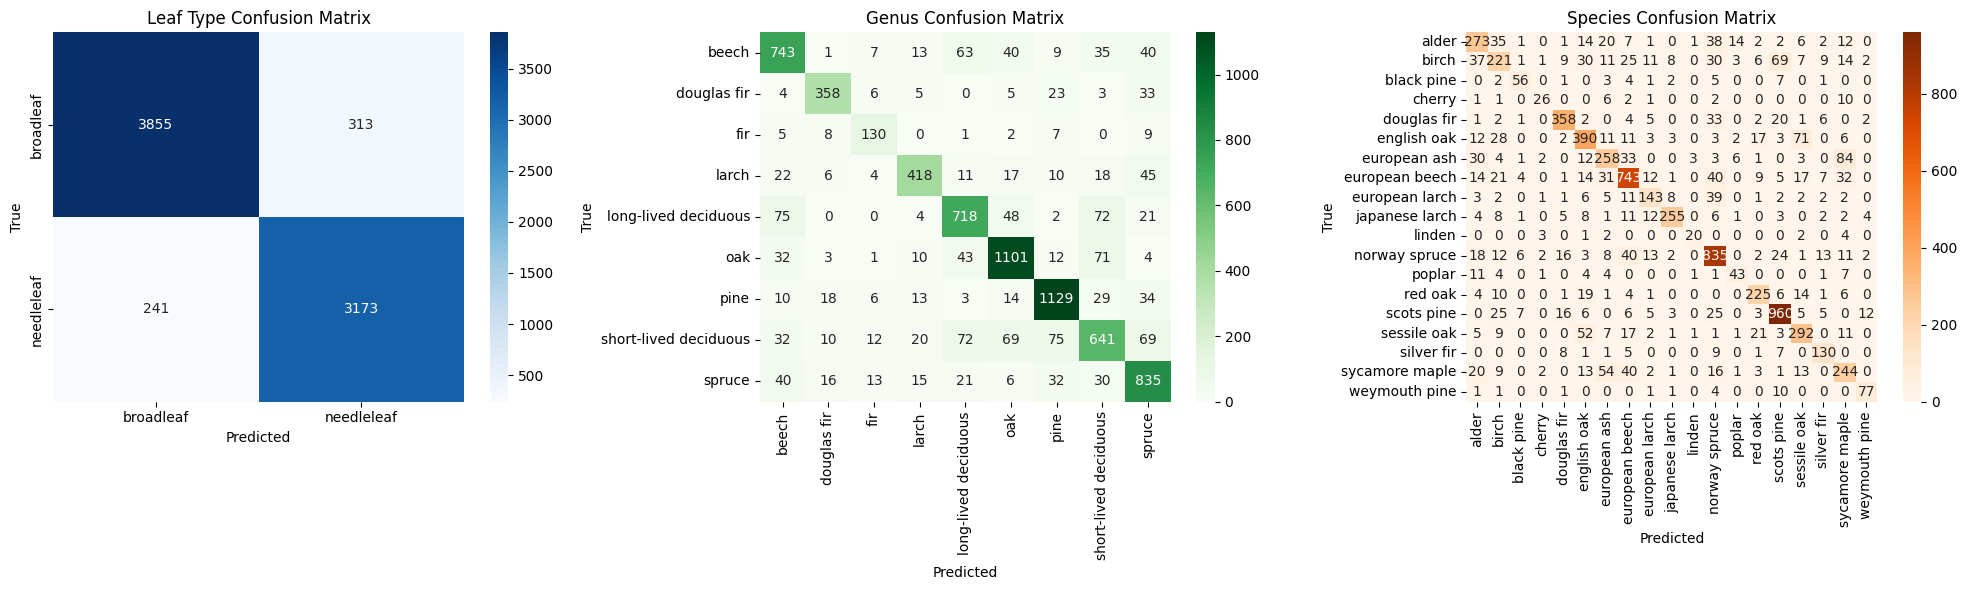

Confusion matrices saved to hierarchical_confusion_matrices.png
Confusion matrices saved as numpy arrays.

Current working directory: /kaggle/working
Check this directory for the following files:
- leaf_classification_report.txt
- genus_classification_report.txt
- species_classification_report.txt
- detailed_evaluation_report.txt
- hierarchical_confusion_matrices.png
- leaf_confusion_matrix.npy
- genus_confusion_matrix.npy
- species_confusion_matrix.npy

=== TRAINING AND EVALUATION COMPLETE ===
Model saved as 'hierarchical_tree_classifier.pkl'
Validation data, reports, and confusion matrices saved successfully!


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import os
warnings.filterwarnings('ignore')

class HierarchicalTreeClassifier:
    def __init__(self, leaf_types, genus, species):
        self.leaf_types = np.array(leaf_types, dtype=str)
        self.genus = np.array(genus, dtype=str)
        self.species = np.array(species, dtype=str)
        
        self.leaf_encoder = LabelEncoder()
        self.genus_encoder = LabelEncoder()
        self.species_encoder = LabelEncoder()
        
        self.leaf_model = None
        self.genus_models = {}
        self.species_models = {}
        
        self.genus_class_mappings = {}
        self.species_class_mappings = {}
        
        self.scaler = StandardScaler()
        self.hierarchy = self._build_hierarchy()
        
    def _build_hierarchy(self):
        hierarchy = defaultdict(lambda: defaultdict(set))
        for i in range(len(self.leaf_types)):
            leaf = self.leaf_types[i]
            genus = self.genus[i]
            species = self.species[i]
            hierarchy[leaf][genus].add(species)
        return {leaf: {genus: list(species) for genus, species in genera.items()} 
                for leaf, genera in hierarchy.items()}
    
    def _create_base_model(self, n_classes, class_weights=None):
        xgb_model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=n_classes,
            max_depth=6,
            learning_rate=0.05,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='mlogloss',
            tree_method='gpu_hist',  # Enable GPU acceleration
            device='cuda'
        )
        return xgb_model
    
    def fit(self, X, validation_split=0.2, use_smote=True):
        print("Starting training...")
        
        # Encode labels
        y_leaf_encoded = self.leaf_encoder.fit_transform(self.leaf_types)
        y_genus_encoded = self.genus_encoder.fit_transform(self.genus)
        y_species_encoded = self.species_encoder.fit_transform(self.species)
        
        # Debug: Print unique labels
        print("self.leaf_encoder.classes_:", self.leaf_encoder.classes_)
        print("self.genus_encoder.classes_:", self.genus_encoder.classes_)
        print("self.species_encoder.classes_:", self.species_encoder.classes_)
        
        # Flatten features
        X_flat = X.reshape(X.shape[0], -1)
        
        # Train-validation split
        indices = np.arange(len(X_flat))
        train_idx, val_idx = train_test_split(
            indices, test_size=validation_split, stratify=y_species_encoded, random_state=42
        )
        X_train, X_val = X_flat[train_idx], X_flat[val_idx]
        y_leaf_train, y_leaf_val = y_leaf_encoded[train_idx], y_leaf_encoded[val_idx]
        y_genus_train, y_genus_val = y_genus_encoded[train_idx], y_genus_encoded[val_idx]
        y_species_train, y_species_val = y_species_encoded[train_idx], y_species_encoded[val_idx]
        
        # Debug: Verify dataset sizes and labels
        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Unique leaf types (train): {np.unique(self.leaf_encoder.inverse_transform(y_leaf_train))}")
        print(f"Unique genera (train): {np.unique(self.genus_encoder.inverse_transform(y_genus_train))}")
        print(f"Unique species (train): {np.unique(self.species_encoder.inverse_transform(y_species_train))}")
        print(f"Unique leaf types (val): {np.unique(self.leaf_encoder.inverse_transform(y_leaf_val))}")
        print(f"Unique genera (val): {np.unique(self.genus_encoder.inverse_transform(y_genus_val))}")
        print(f"Unique species (val): {np.unique(self.species_encoder.inverse_transform(y_species_val))}")
        
        # Apply SMOTE
        if use_smote:
            print("Applying SMOTE for class balancing...")
            smote = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1)
            try:
                print("Shape of X_train before SMOTE:", X_train.shape)
                print("Shape of y_species_train before SMOTE:", y_species_train.shape)
                print("Type of y_species_train:", type(y_species_train))
                print("Sample y_species_train values:", y_species_train[:5])
                
                X_train_resampled, y_species_train_resampled = smote.fit_resample(X_train, y_species_train)
                y_leaf_train_resampled = []
                y_genus_train_resampled = []
                
                for species_idx in y_species_train_resampled:
                    species_name = self.species_encoder.inverse_transform([species_idx])[0]
                    found = False
                    for leaf_name, genera in self.hierarchy.items():
                        for genus_name, species_list in genera.items():
                            if species_name in species_list:
                                y_leaf_train_resampled.append(self.leaf_encoder.transform([leaf_name])[0])
                                y_genus_train_resampled.append(self.genus_encoder.transform([genus_name])[0])
                                found = True
                                break
                        if found:
                            break
                    if not found:
                        print(f"Warning: Could not find genus for synthetic species '{species_name}'")
                        original_indices = np.where(y_species_train == species_idx)[0]
                        if len(original_indices) > 0:
                            orig_idx = original_indices[0]
                            y_leaf_train_resampled.append(y_leaf_train[orig_idx])
                            y_genus_train_resampled.append(y_genus_train[orig_idx])
                        else:
                            most_common_genus = np.argmax(np.bincount(y_genus_train))
                            most_common_leaf = np.argmax(np.bincount(y_leaf_train))
                            y_leaf_train_resampled.append(most_common_leaf)
                            y_genus_train_resampled.append(most_common_genus)
                
                X_train = X_train_resampled
                y_leaf_train = np.array(y_leaf_train_resampled)
                y_genus_train = np.array(y_genus_train_resampled)
                y_species_train = y_species_train_resampled
            except Exception as e:
                print(f"SMOTE failed: {e}. Proceeding without SMOTE.")
                use_smote = False
        
        # Scale features (after SMOTE)
        print("Scaling features...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Level 1: Leaf Type Model
        print("\nTraining Level 1 (Leaf Type) model...")
        leaf_weights = compute_class_weight('balanced', classes=np.unique(y_leaf_train), y=y_leaf_train)
        leaf_class_weights = dict(zip(np.unique(y_leaf_train), leaf_weights))
        
        self.leaf_model = self._create_base_model(len(self.leaf_encoder.classes_), class_weights=leaf_class_weights)
        self.leaf_model.fit(X_train_scaled, y_leaf_train, sample_weight=[leaf_class_weights.get(y, 1.0) for y in y_leaf_train])
        
        # Level 2: Genus Models
        print("\nTraining Level 2 (Genus) models...")
        for leaf_type in np.unique(y_leaf_train):
            leaf_name = self.leaf_encoder.inverse_transform([leaf_type])[0]
            mask = y_leaf_train == leaf_type
            X_leaf = X_train_scaled[mask]
            y_genus_leaf = y_genus_train[mask]
            
            if len(np.unique(y_genus_leaf)) < 2:
                print(f"Skipping genus model for leaf type {leaf_name}: only {len(np.unique(y_genus_leaf))} class")
                continue
                
            local_genus_encoder = LabelEncoder()
            y_genus_leaf_local = local_genus_encoder.fit_transform(self.genus_encoder.inverse_transform(y_genus_leaf))
            print(f"Leaf type {leaf_name}: local_genus_encoder.classes_ = {local_genus_encoder.classes_}")
            
            genus_weights = compute_class_weight('balanced', classes=np.unique(y_genus_leaf_local), y=y_genus_leaf_local)
            genus_class_weights = dict(zip(np.unique(y_genus_leaf_local), genus_weights))
            
            self.genus_class_mappings[leaf_type] = {
                'local_to_global': {},
                'global_to_local': {}
            }
            for i in range(len(local_genus_encoder.classes_)):
                local_label = str(local_genus_encoder.inverse_transform([i])[0])
                try:
                    global_idx = self.genus_encoder.transform([local_label])[0]
                    self.genus_class_mappings[leaf_type]['local_to_global'][i] = global_idx
                    self.genus_class_mappings[leaf_type]['global_to_local'][global_idx] = i
                except ValueError as e:
                    print(f"Error mapping local genus label '{local_label}' for leaf type {leaf_name}: {e}")
                    continue
            
            if self.genus_class_mappings[leaf_type]['local_to_global']:
                self.genus_models[leaf_type] = self._create_base_model(len(local_genus_encoder.classes_), genus_class_weights)
                self.genus_models[leaf_type].fit(X_leaf, y_genus_leaf_local, sample_weight=[genus_class_weights.get(y, 1.0) for y in y_genus_leaf_local])
            else:
                print(f"No valid genus mappings for leaf type {leaf_name}. Skipping.")
        
        # Level 3: Species Models
        print("\nTraining Level 3 (Species) models...")
        for genus_type in np.unique(y_genus_train):
            genus_name = self.genus_encoder.inverse_transform([genus_type])[0]
            mask = y_genus_train == genus_type
            X_genus = X_train_scaled[mask]
            y_species_genus = y_species_train[mask]
            
            if len(np.unique(y_species_genus)) < 2:
                print(f"Skipping species model for genus {genus_name}: only {len(np.unique(y_species_genus))} class")
                continue
                
            local_species_encoder = LabelEncoder()
            y_species_genus_local = local_species_encoder.fit_transform(self.species_encoder.inverse_transform(y_species_genus))
            print(f"Genus {genus_name}: local_species_encoder.classes_ = {local_species_encoder.classes_}")
            
            species_weights = compute_class_weight('balanced', classes=np.unique(y_species_genus_local), y=y_species_genus_local)
            species_class_weights = dict(zip(np.unique(y_species_genus_local), species_weights))
            
            self.species_class_mappings[genus_type] = {
                'local_to_global': {},
                'global_to_local': {}
            }
            for i in range(len(local_species_encoder.classes_)):
                local_label = str(local_species_encoder.inverse_transform([i])[0])
                try:
                    global_idx = self.species_encoder.transform([local_label])[0]
                    self.species_class_mappings[genus_type]['local_to_global'][i] = global_idx
                    self.species_class_mappings[genus_type]['global_to_local'][global_idx] = i
                except ValueError as e:
                    print(f"Error mapping local species label '{local_label}' for genus {genus_name}: {e}")
                    continue
            
            if self.species_class_mappings[genus_type]['local_to_global']:
                self.species_models[genus_type] = self._create_base_model(len(local_species_encoder.classes_), species_class_weights)
                self.species_models[genus_type].fit(X_genus, y_species_genus_local, sample_weight=[species_class_weights.get(y, 1.0) for y in y_species_genus_local])
            else:
                print(f"No valid species mappings for genus {genus_name}. Skipping.")
        
        # Save model and validation data
        model_data = {
            'leaf_model': self.leaf_model,
            'genus_models': self.genus_models,
            'species_models': self.species_models,
            'leaf_encoder': self.leaf_encoder,
            'genus_encoder': self.genus_encoder,
            'species_encoder': self.species_encoder,
            'scaler': self.scaler,
            'hierarchy': self.hierarchy,
            'genus_class_mappings': self.genus_class_mappings,
            'species_class_mappings': self.species_class_mappings
        }
        joblib.dump(model_data, 'hierarchical_tree_classifier.pkl')
        np.save('validation_features.npy', X_val)
        np.save('validation_labels_leaf.npy', y_leaf_val)
        np.save('validation_labels_genus.npy', y_genus_val)
        np.save('validation_labels_species.npy', y_species_val)
        print("\nModel and validation data saved.")

    def predict(self, X):
        """
        Make hierarchical predictions
        
        Args:
            X: Feature matrix (expected shape: [n_samples, height, width, n_bands])
            
        Returns:
            dict: Predictions for each level
        """
        if len(X.shape) > 2:
            X_flat = X.reshape(X.shape[0], -1)
        else:
            X_flat = X
        
        X_scaled = self.scaler.transform(X_flat)
        
        # Level 1: Predict leaf type
        leaf_proba = self.leaf_model.predict_proba(X_scaled)
        leaf_pred = np.argmax(leaf_proba, axis=1).astype(np.int64)
        
        # Level 2: Predict genus based on leaf type
        genus_pred = np.full(len(X_scaled), -1, dtype=np.int64)
        genus_proba = np.zeros((len(X_scaled), len(self.genus_encoder.classes_)))
        
        unique_leaf_types = np.unique(leaf_pred)
        for leaf_type in unique_leaf_types:
            if leaf_type in self.genus_models:
                indices = np.where(leaf_pred == leaf_type)[0]
                X_leaf = X_scaled[indices]
                
                local_genus_pred = self.genus_models[leaf_type].predict(X_leaf)
                local_genus_proba = self.genus_models[leaf_type].predict_proba(X_leaf)
                
                # Ensure local_genus_pred is 1D integer
                if local_genus_pred.ndim > 1:
                    local_genus_pred = np.argmax(local_genus_pred, axis=1).astype(np.int64)
                
                for i, idx in enumerate(indices):
                    global_genus_pred = self.genus_class_mappings[leaf_type]['local_to_global'].get(int(local_genus_pred[i]), -1)
                    if global_genus_pred == -1:
                        global_genus_pred = self.genus_encoder.transform(['oak'])[0]  # Fallback
                    genus_pred[idx] = global_genus_pred
                    
                    for local_idx, prob in enumerate(local_genus_proba[i]):
                        global_idx = self.genus_class_mappings[leaf_type]['local_to_global'].get(int(local_idx), -1)
                        if global_idx != -1:
                            genus_proba[idx, global_idx] = prob
            else:
                print(f"Warning: Leaf type {leaf_type} not found in genus_models")
        
        # Level 3: Predict species based on genus
        species_pred = np.full(len(X_scaled), -1, dtype=np.int64)
        species_proba = np.zeros((len(X_scaled), len(self.species_encoder.classes_)))
        
        # Handle genera with single species
        single_species_map = {}
        try:
            single_species_mappings = [
                ('beech', 'european beech'),
                ('douglas fir', 'douglas fir'),
                ('fir', 'silver fir'),
                ('spruce', 'norway spruce')
            ]
            for genus_name, species_name in single_species_mappings:
                try:
                    genus_idx = self.genus_encoder.transform([genus_name])[0]
                    species_idx = self.species_encoder.transform([species_name])[0]
                    single_species_map[genus_idx] = species_idx
                except ValueError:
                    continue
        except Exception as e:
            print(f"Warning: Could not create single species mappings: {e}")
        
        unique_genus_types = np.unique(genus_pred[genus_pred != -1])
        for genus_type in unique_genus_types:
            indices = np.where(genus_pred == genus_type)[0]
            X_genus = X_scaled[indices]
            
            if genus_type in self.species_models:
                local_species_pred = self.species_models[genus_type].predict(X_genus)
                if local_species_pred.ndim > 1:
                    local_species_pred = np.argmax(local_species_pred, axis=1).astype(np.int64)
                
                local_species_proba = self.species_models[genus_type].predict_proba(X_genus)
                
                for i, idx in enumerate(indices):
                    global_species_pred = self.species_class_mappings[genus_type]['local_to_global'].get(int(local_species_pred[i]), -1)
                    if global_species_pred == -1:
                        global_species_pred = self.species_encoder.transform(['scots pine'])[0]
                    species_pred[idx] = global_species_pred
                    
                    for local_idx, prob in enumerate(local_species_proba[i]):
                        global_idx = self.species_class_mappings[genus_type]['local_to_global'].get(int(local_idx), -1)
                        if global_idx != -1:
                            species_proba[idx, global_idx] = prob
            elif genus_type in single_species_map:
                species_pred[indices] = single_species_map[genus_type]
                species_proba[indices, single_species_map[genus_type]] = 1.0
            else:
                print(f"Warning: Genus type {genus_type} not found in species_models or single_species_map")
        
        # Debug: Check prediction shapes and types
        print("leaf_pred shape:", leaf_pred.shape, "dtype:", leaf_pred.dtype)
        print("genus_pred shape:", genus_pred.shape, "dtype:", genus_pred.dtype)
        print("species_pred shape:", species_pred.shape, "dtype:", species_pred.dtype)
        
        return {
            'leaf_type': leaf_pred,
            'genus': genus_pred,
            'species': species_pred,
            'leaf_proba': leaf_proba,
            'genus_proba': genus_proba,
            'species_proba': species_proba
        }

    def evaluate(self, X, y_leaf, y_genus, y_species):
        """
        Evaluate model performance on provided data
        """
        predictions = self.predict(X)
        
        # Ensure labels are 1D integer arrays
        y_leaf = np.array(y_leaf, dtype=np.int64)
        y_genus = np.array(y_genus, dtype=np.int64)
        y_species = np.array(y_species, dtype=np.int64)
        
        # Convert one-hot encoded labels to integer labels if necessary
        if len(y_leaf.shape) > 1:
            print("Converting y_leaf from one-hot to integer labels")
            y_leaf = np.argmax(y_leaf, axis=1).astype(np.int64)
        if len(y_genus.shape) > 1:
            print("Converting y_genus from one-hot to integer labels")
            y_genus = np.argmax(y_genus, axis=1).astype(np.int64)
        if len(y_species.shape) > 1:
            print("Converting y_species from one-hot to integer labels")
            y_species = np.argmax(y_species, axis=1).astype(np.int64)
        
        # Clean genus labels to ensure they are valid
        valid_genus_labels = set(self.genus_encoder.transform(self.genus_encoder.classes_))
        y_genus_clean = np.array([label if label in valid_genus_labels else list(valid_genus_labels)[0] for label in y_genus], dtype=np.int64)
        genus_pred_clean = np.array([pred if pred in valid_genus_labels else list(valid_genus_labels)[0] for pred in predictions['genus']], dtype=np.int64)
        
        # Debug: Check label and prediction shapes
        print("y_leaf shape:", y_leaf.shape, "dtype:", y_leaf.dtype)
        print("predictions['leaf_type'] shape:", predictions['leaf_type'].shape, "dtype:", predictions['leaf_type'].dtype)
        print("y_genus_clean shape:", y_genus_clean.shape, "dtype:", y_genus_clean.dtype)
        print("genus_pred_clean shape:", genus_pred_clean.shape, "dtype:", genus_pred_clean.dtype)
        print("y_species shape:", y_species.shape, "dtype:", y_species.dtype)
        print("predictions['species'] shape:", predictions['species'].shape, "dtype:", predictions['species'].dtype)
        
        leaf_accuracy = accuracy_score(y_leaf, predictions['leaf_type'])
        genus_accuracy = accuracy_score(y_genus_clean, genus_pred_clean)
        species_accuracy = accuracy_score(y_species, predictions['species'])
        
        hierarchical_accuracy = np.mean(
            (predictions['leaf_type'] == y_leaf) & 
            (genus_pred_clean == y_genus_clean) & 
            (predictions['species'] == y_species)
        )
        
        leaf_report = classification_report(y_leaf, predictions['leaf_type'], 
                                           target_names=self.leaf_encoder.classes_, 
                                           output_dict=True, zero_division=0)
        
        genus_report = classification_report(y_genus_clean, genus_pred_clean, 
                                            target_names=self.genus_encoder.classes_, 
                                            output_dict=True, zero_division=0)
        
        species_report = classification_report(y_species, predictions['species'], 
                                              target_names=self.species_encoder.classes_, 
                                              output_dict=True, zero_division=0)
        
        # Save classification reports
        with open('leaf_classification_report.txt', 'w') as f:
            f.write(str(pd.DataFrame(leaf_report).transpose().round(4)))
        with open('genus_classification_report.txt', 'w') as f:
            f.write(str(pd.DataFrame(genus_report).transpose().round(4)))
        with open('species_classification_report.txt', 'w') as f:
            f.write(str(pd.DataFrame(species_report).transpose().round(4)))
        print("Classification reports saved as text files.")
        
        return {
            'leaf_accuracy': leaf_accuracy,
            'genus_accuracy': genus_accuracy,
            'species_accuracy': species_accuracy,
            'hierarchical_accuracy': hierarchical_accuracy,
            'leaf_report': leaf_report,
            'genus_report': genus_report,
            'species_report': species_report
        }
    
    def plot_confusion_matrices(self, X, y_leaf, y_genus, y_species, save_path='hierarchical_confusion_matrices.png'):
        predictions = self.predict(X)
        
        # Ensure labels are 1D integer arrays
        y_leaf = np.array(y_leaf, dtype=np.int64)
        y_genus = np.array(y_genus, dtype=np.int64)
        y_species = np.array(y_species, dtype=np.int64)
        
        # Convert one-hot encoded labels to integer labels if necessary
        if len(y_leaf.shape) > 1:
            y_leaf = np.argmax(y_leaf, axis=1).astype(np.int64)
        if len(y_genus.shape) > 1:
            y_genus = np.argmax(y_genus, axis=1).astype(np.int64)
        if len(y_species.shape) > 1:
            y_species = np.argmax(y_species, axis=1).astype(np.int64)
        
        # Clean genus labels
        valid_genus_labels = set(self.genus_encoder.transform(self.genus_encoder.classes_))
        y_genus_clean = np.array([label if label in valid_genus_labels else list(valid_genus_labels)[0] for label in y_genus], dtype=np.int64)
        genus_pred_clean = np.array([pred if pred in valid_genus_labels else list(valid_genus_labels)[0] for pred in predictions['genus']], dtype=np.int64)
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        cm_leaf = confusion_matrix(y_leaf, predictions['leaf_type'])
        sns.heatmap(cm_leaf, annot=True, fmt='d', 
                   xticklabels=self.leaf_encoder.classes_, 
                   yticklabels=self.leaf_encoder.classes_, 
                   cmap='Blues', ax=axes[0])
        axes[0].set_title('Leaf Type Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        
        cm_genus = confusion_matrix(y_genus_clean, genus_pred_clean)
        sns.heatmap(cm_genus, annot=True, fmt='d', 
                   xticklabels=self.genus_encoder.classes_, 
                   yticklabels=self.genus_encoder.classes_, 
                   cmap='Greens', ax=axes[1])
        axes[1].set_title('Genus Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        
        cm_species = confusion_matrix(y_species, predictions['species'])
        sns.heatmap(cm_species, annot=True, fmt='d', 
                   xticklabels=self.species_encoder.classes_, 
                   yticklabels=self.species_encoder.classes_, 
                   cmap='Oranges', ax=axes[2])
        axes[2].set_title('Species Confusion Matrix')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('True')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Confusion matrices saved to {save_path}")
        
        # Save confusion matrices as numpy arrays
        np.save('leaf_confusion_matrix.npy', cm_leaf)
        np.save('genus_confusion_matrix.npy', cm_genus)
        np.save('species_confusion_matrix.npy', cm_species)
        print("Confusion matrices saved as numpy arrays.")
    
    def detailed_evaluation_report(self, X, y_leaf, y_genus, y_species):
        results = self.evaluate(X, y_leaf, y_genus, y_species)
        
        report_content = []
        report_content.append("=" * 70)
        report_content.append("HIERARCHICAL TREE CLASSIFIER - DETAILED EVALUATION REPORT")
        report_content.append("=" * 70)
        
        report_content.append(f"\nOVERALL ACCURACY METRICS:")
        report_content.append(f"  Leaf Type Accuracy:     {results['leaf_accuracy']:.4f}")
        report_content.append(f"  Genus Accuracy:         {results['genus_accuracy']:.4f}")
        report_content.append(f"  Species Accuracy:       {results['species_accuracy']:.4f}")
        report_content.append(f"  Hierarchical Accuracy:  {results['hierarchical_accuracy']:.4f}")
        
        report_content.append(f"\nLEAF TYPE CLASSIFICATION REPORT:")
        report_content.append("-" * 50)
        leaf_df = pd.DataFrame(results['leaf_report']).transpose()
        report_content.append(str(leaf_df.round(4)))
        
        report_content.append(f"\nGENUS CLASSIFICATION REPORT:")
        report_content.append("-" * 50)
        genus_df = pd.DataFrame(results['genus_report']).transpose()
        report_content.append(str(genus_df.round(4)))
        
        report_content.append(f"\nSPECIES CLASSIFICATION REPORT:")
        report_content.append("-" * 50)
        species_df = pd.DataFrame(results['species_report']).transpose()
        report_content.append(str(species_df.round(4)))
        
        # Save the detailed report
        with open('detailed_evaluation_report.txt', 'w') as f:
            f.write("\n".join(report_content))
        print("Detailed evaluation report saved as 'detailed_evaluation_report.txt'")
        
        return results
    
    def analyze_prediction_confidence(self, X, y_leaf, y_genus, y_species):
        predictions = self.predict(X)
        
        # Ensure labels are 1D integer arrays
        y_leaf = np.array(y_leaf, dtype=np.int64)
        y_genus = np.array(y_genus, dtype=np.int64)
        y_species = np.array(y_species, dtype=np.int64)
        
        # Convert one-hot encoded labels to integer labels if necessary
        if len(y_leaf.shape) > 1:
            y_leaf = np.argmax(y_leaf, axis=1).astype(np.int64)
        if len(y_genus.shape) > 1:
            y_genus = np.argmax(y_genus, axis=1).astype(np.int64)
        if len(y_species.shape) > 1:
            y_species = np.argmax(y_species, axis=1).astype(np.int64)
        
        leaf_confidence = np.max(predictions['leaf_proba'], axis=1)
        genus_confidence = np.max(predictions['genus_proba'], axis=1)
        species_confidence = np.max(predictions['species_proba'], axis=1)
        
        leaf_correct = predictions['leaf_type'] == y_leaf
        genus_correct = predictions['genus'] == y_genus
        species_correct = predictions['species'] == y_species
        
        print("\n" + "=" * 70)
        print("PREDICTION CONFIDENCE ANALYSIS")
        print("=" * 70)
        
        print(f"\nAverage Confidence Scores:")
        print(f"  Leaf Type:  {np.mean(leaf_confidence):.4f}")
        print(f"  Genus:      {np.mean(genus_confidence):.4f}")
        print(f"  Species:    {np.mean(species_confidence):.4f}")
        
        print(f"\nConfidence for Correct Predictions:")
        print(f"  Leaf Type:  {np.mean(leaf_confidence[leaf_correct]):.4f}")
        print(f"  Genus:      {np.mean(genus_confidence[genus_correct]):.4f}")
        print(f"  Species:    {np.mean(species_confidence[species_correct]):.4f}")
        
        print(f"\nConfidence for Incorrect Predictions:")
        print(f"  Leaf Type:  {np.mean(leaf_confidence[~leaf_correct]):.4f}")
        print(f"  Genus:      {np.mean(genus_confidence[~genus_correct]):.4f}")
        print(f"  Species:    {np.mean(species_confidence[~species_correct]):.4f}")
        
        low_confidence_threshold = 0.5
        low_conf_indices = np.where(species_confidence < low_confidence_threshold)[0]
        
        if len(low_conf_indices) > 0:
            print(f"\nLow Confidence Predictions (< {low_confidence_threshold}):")
            print(f"  Count: {len(low_conf_indices)} ({len(low_conf_indices)/len(X)*100:.1f}%)")
            
            for i in low_conf_indices[:5]:
                true_leaf = self.leaf_encoder.inverse_transform([y_leaf[i]])[0]
                true_genus = self.genus_encoder.inverse_transform([y_genus[i]])[0]
                true_species = self.species_encoder.inverse_transform([y_species[i]])[0]
                
                pred_leaf = self.leaf_encoder.inverse_transform([predictions['leaf_type'][i]])[0]
                pred_genus = self.genus_encoder.inverse_transform([predictions['genus'][i]])[0]
                pred_species = self.species_encoder.inverse_transform([predictions['species'][i]])[0]
                
                print(f"    Sample {i}: True({true_leaf}/{true_genus}/{true_species}) -> "
                      f"Pred({pred_leaf}/{pred_genus}/{pred_species}) "
                      f"Conf: {species_confidence[i]:.3f}")

    def save_model(self, filename='hierarchical_tree_classifier.pkl'):
        model_data = {
            'leaf_model': self.leaf_model,
            'genus_models': self.genus_models,
            'species_models': self.species_models,
            'leaf_encoder': self.leaf_encoder,
            'genus_encoder': self.genus_encoder,
            'species_encoder': self.species_encoder,
            'scaler': self.scaler,
            'hierarchy': self.hierarchy,
            'genus_class_mappings': self.genus_class_mappings,
            'species_class_mappings': self.species_class_mappings
        }
        joblib.dump(model_data, filename)
        print(f"Model saved as {filename}")

    @classmethod
    def load_model(cls, filename):
        model_data = joblib.load(filename)
        instance = cls.__new__(cls)
        instance.leaf_model = model_data['leaf_model']
        instance.genus_models = model_data['genus_models']
        instance.species_models = model_data['species_models']
        instance.leaf_encoder = model_data['leaf_encoder']
        instance.genus_encoder = model_data['genus_encoder']
        instance.species_encoder = model_data['species_encoder']
        instance.scaler = model_data['scaler']
        instance.hierarchy = model_data['hierarchy']
        instance.genus_class_mappings = model_data['genus_class_mappings']
        instance.species_class_mappings = model_data['species_class_mappings']
        return instance

if __name__ == "__main__":
    try:
        print("Loading preprocessed data...")
        X = np.load('features.npy')
        y_l1 = np.load('labels_l1.npy')
        y_l2 = np.load('labels_l2.npy')
        y_l3 = np.load('labels_l3.npy')
        
        print("Loaded preprocessed data successfully!")
        print(f"Features shape: {X.shape}")
        print(f"Labels - L1: {len(np.unique(y_l1))}, L2: {len(np.unique(y_l2))}, L3: {len(np.unique(y_l3))}")
        
        # Debug: Check input label formats
        print("y_l1 shape:", y_l1.shape, "dtype:", y_l1.dtype)
        print("y_l1 sample:", y_l1[:5])
        print("y_l2 shape:", y_l2.shape, "dtype:", y_l2.dtype)
        print("y_l2 sample:", y_l2[:5])
        print("y_l3 shape:", y_l3.shape, "dtype:", y_l3.dtype)
        print("y_l3 sample:", y_l3[:5])
        
        # Convert one-hot encoded input labels to strings if necessary
        if len(y_l1.shape) > 1:
            print("Converting y_l1 from one-hot to string labels")
            leaf_classes = ['broadleaf', 'needleleaf']  # Adjust based on your classes
            y_l1 = np.array([leaf_classes[i] for i in np.argmax(y_l1, axis=1)])
        if len(y_l2.shape) > 1:
            print("Converting y_l2 from one-hot to string labels")
            genus_classes = ['beech', 'douglas fir', 'fir', 'larch', 'long-lived deciduous', 'oak', 'pine', 'short-lived deciduous', 'spruce']
            y_l2 = np.array([genus_classes[i] for i in np.argmax(y_l2, axis=1)])
        if len(y_l3.shape) > 1:
            print("Converting y_l3 from one-hot to string labels")
            species_classes = ['alder', 'birch', 'black pine', 'cherry', 'douglas fir', 'english oak', 'european beech', 'european ash', 'european larch', 'japanese larch', 'linden', 'norway spruce', 'poplar', 'red oak', 'scots pine', 'sessile oak', 'silver fir', 'sycamore maple', 'weymouth pine']
            y_l3 = np.array([species_classes[i] for i in np.argmax(y_l3, axis=1)])
        
        print("\nInitializing hierarchical model...")
        model = HierarchicalTreeClassifier(y_l1, y_l2, y_l3)
        
        print("Training hierarchical model...")
        model.fit(X)
        
        print("\nSaving model...")
        model.save_model('hierarchical_tree_classifier.pkl')
        
        # Load validation data
        print("\nLoading validation data for evaluation...")
        X_val = np.load('validation_features.npy')
        y_leaf_val = np.load('validation_labels_leaf.npy')
        y_genus_val = np.load('validation_labels_genus.npy')
        y_species_val = np.load('validation_labels_species.npy')
        
        # Debug: Check validation label formats
        print("y_leaf_val shape:", y_leaf_val.shape, "dtype:", y_leaf_val.dtype)
        print("y_leaf_val sample:", y_leaf_val[:5])
        print("y_genus_val shape:", y_genus_val.shape, "dtype:", y_genus_val.dtype)
        print("y_genus_val sample:", y_genus_val[:5])
        print("y_species_val shape:", y_species_val.shape, "dtype:", y_species_val.dtype)
        print("y_species_val sample:", y_species_val[:5])
        
        # Convert one-hot encoded validation labels to integer labels if necessary
        if len(y_leaf_val.shape) > 1:
            print("Converting y_leaf_val from one-hot to integer labels")
            y_leaf_val = np.argmax(y_leaf_val, axis=1).astype(np.int64)
        if len(y_genus_val.shape) > 1:
            print("Converting y_genus_val from one-hot to integer labels")
            y_genus_val = np.argmax(y_genus_val, axis=1).astype(np.int64)
        if len(y_species_val.shape) > 1:
            print("Converting y_species_val from one-hot to integer labels")
            y_species_val = np.argmax(y_species_val, axis=1).astype(np.int64)
        
        # Ensure integer type
        y_leaf_val = np.array(y_leaf_val, dtype=np.int64)
        y_genus_val = np.array(y_genus_val, dtype=np.int64)
        y_species_val = np.array(y_species_val, dtype=np.int64)
        
        # Ensure validation data is not empty
        if X_val.size == 0 or y_leaf_val.size == 0 or y_genus_val.size == 0 or y_species_val.size == 0:
            raise ValueError("Validation data is empty or invalid.")
        
        # Evaluate the model
        print("\nEvaluating model...")
        results = model.evaluate(X_val, y_leaf_val, y_genus_val, y_species_val)
        
        # Generate detailed evaluation report
        print("\nGenerating detailed evaluation report...")
        model.detailed_evaluation_report(X_val, y_leaf_val, y_genus_val, y_species_val)
        
        # Plot and save confusion matrices
        print("\nPlotting and saving confusion matrices...")
        model.plot_confusion_matrices(X_val, y_leaf_val, y_genus_val, y_species_val)
        
        # Print current working directory
        print(f"\nCurrent working directory: {os.getcwd()}")
        print("Check this directory for the following files:")
        print("- leaf_classification_report.txt")
        print("- genus_classification_report.txt")
        print("- species_classification_report.txt")
        print("- detailed_evaluation_report.txt")
        print("- hierarchical_confusion_matrices.png")
        print("- leaf_confusion_matrix.npy")
        print("- genus_confusion_matrix.npy")
        print("- species_confusion_matrix.npy")
        
        print("\n=== TRAINING AND EVALUATION COMPLETE ===")
        print("Model saved as 'hierarchical_tree_classifier.pkl'")
        print("Validation data, reports, and confusion matrices saved successfully!")
        
    except FileNotFoundError as e:
        print(f"Error: Could not find preprocessed data files: {e}")
        print("Please run the preprocessing code first to generate the required .npy files")
    except PermissionError as e:
        print(f"Error: Permission issue when saving files: {e}")
        print("Check if you have write permissions in the current directory:", os.getcwd())
    except Exception as e:
        print(f"Error during model training or evaluation: {e}")
        import traceback
        traceback.print_exc()

TESTING HIERARCHICAL TREE CLASSIFIER ON SATELLITE DATA

1. Loading trained model...
✓ Model loaded successfully!
Model encoders:
  Leaf types: 2 classes
  Genera: 9 classes
  Species: 19 classes

2. Loading test data from /kaggle/input/final-test-data...
Loading test data from: /kaggle/input/final-test-data
Found 19 GeoJSON test files:
  - broadleaf_beech_european beechmar-oct-2022.geojson
  - broadleaf_long-lived deciduous_cherrymar-oct-2022.geojson
  - broadleaf_long-lived deciduous_european ashmar-oct-2022.geojson
  - broadleaf_long-lived deciduous_lindenmar-oct-2022.geojson
  - broadleaf_long-lived deciduous_sycamore maplemar-oct-2022.geojson
  - broadleaf_oak_english oakmar-oct-2022.geojson
  - broadleaf_oak_red oakmar-oct-2022.geojson
  - broadleaf_oak_sessile oakmar-oct-2022.geojson
  - broadleaf_short-lived deciduous_aldermar-oct-2022.geojson
  - broadleaf_short-lived deciduous_birchmar-oct-2022.geojson
  - broadleaf_short-lived deciduous_poplarmar-oct-2022.geojson
  - needlele

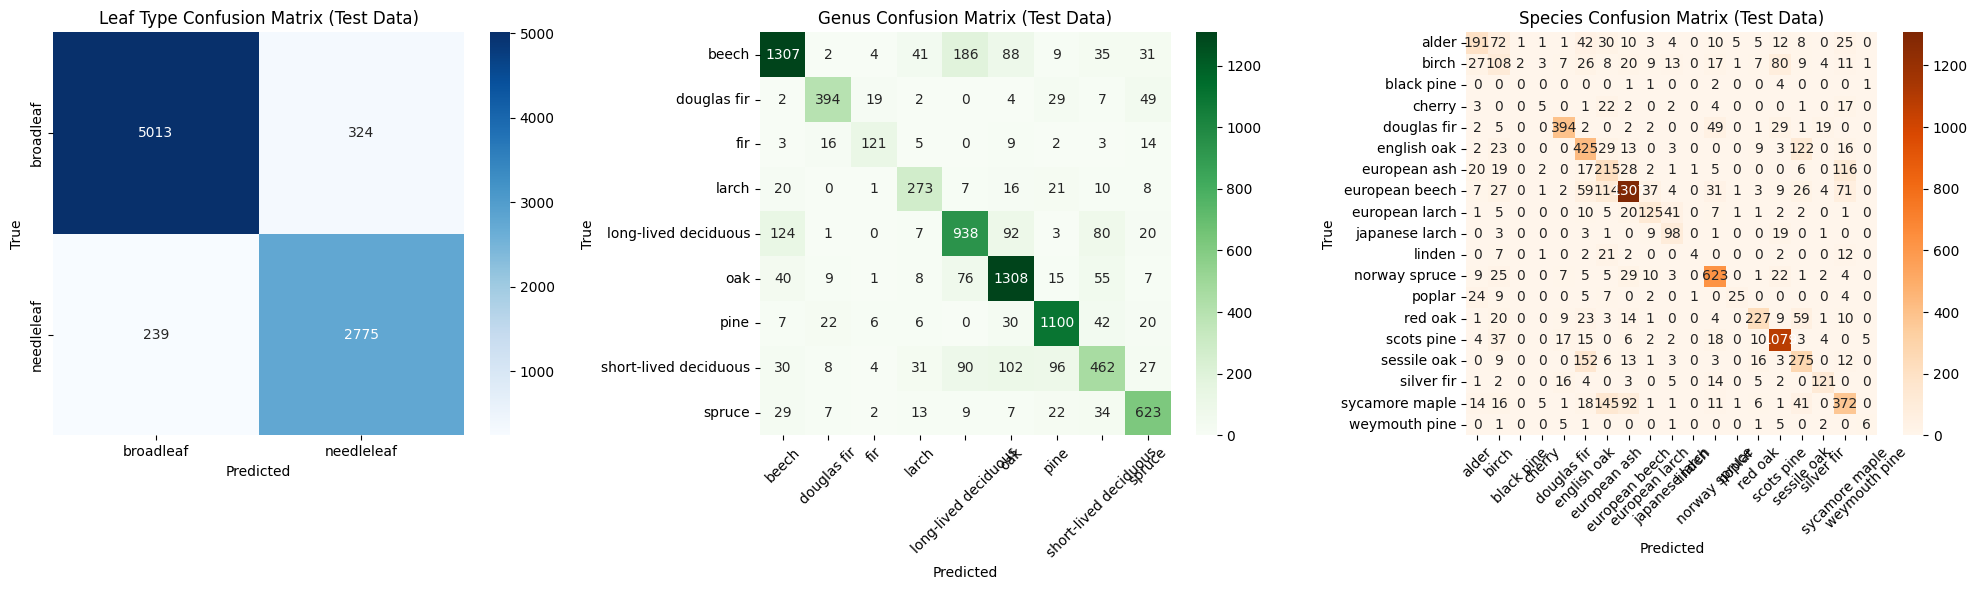

Test confusion matrices saved to test_confusion_matrices.png

7. Analyzing misclassifications...
Prediction times: Leaf=0.27s, Genus=0.81s, Species=0.79s, Total=2.06s

Found 2751 misclassified samples
Showing first 10 examples:
--------------------------------------------------------------------------------
Example 1:
  File: needleleaf_douglas fir_douglas firmar-oct-2022.geojson
  Sample ID: 1
  True:      needleleaf / douglas fir / douglas fir
  Predicted: needleleaf / spruce / norway spruce
  Confidence: 1.000

Example 2:
  File: needleleaf_douglas fir_douglas firmar-oct-2022.geojson
  Sample ID: 6
  True:      needleleaf / douglas fir / douglas fir
  Predicted: needleleaf / spruce / norway spruce
  Confidence: 1.000

Example 3:
  File: needleleaf_douglas fir_douglas firmar-oct-2022.geojson
  Sample ID: 8
  True:      needleleaf / douglas fir / douglas fir
  Predicted: needleleaf / pine / scots pine
  Confidence: 0.978

Example 4:
  File: needleleaf_douglas fir_douglas firmar-oct-20

In [3]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
import time
from pathlib import Path
import ast

warnings.filterwarnings('ignore')

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class HierarchicalTreeClassifier:
    """
    Load only the prediction and evaluation methods for the trained model
    """
    def predict(self, X):
        """
        Make hierarchical predictions
        
        Args:
            X: Feature matrix (expected shape: [n_samples, 5, 5, n_bands])
            
        Returns:
            dict: Predictions for each level
        """
        start_time = time.time()
        
        # Reshape input to match training format (flatten spatial dimensions and channels)
        X_flat = X.reshape(X.shape[0], -1)
        X_scaled = self.scaler.transform(X_flat)
        
        # Level 1: Predict leaf type
        leaf_start = time.time()
        leaf_proba = self.leaf_model.predict_proba(X_scaled)
        leaf_pred = np.argmax(leaf_proba, axis=1)
        leaf_time = time.time() - leaf_start
        
        # Level 2: Predict genus based on leaf type
        genus_start = time.time()
        genus_pred = np.full(len(X_scaled), -1, dtype=np.int64)
        genus_proba = np.zeros((len(X_scaled), len(self.genus_encoder.classes_)))
        
        unique_leaf_types = np.unique(leaf_pred)
        for leaf_type in unique_leaf_types:
            if leaf_type in self.genus_models:
                indices = np.where(leaf_pred == leaf_type)[0]
                X_leaf = X_scaled[indices]
                
                local_genus_pred = self.genus_models[leaf_type].predict(X_leaf)
                local_genus_proba = self.genus_models[leaf_type].predict_proba(X_leaf)
                
                for i, idx in enumerate(indices):
                    global_genus_pred = self.genus_class_mappings[leaf_type]['local_to_global'].get(local_genus_pred[i], -1)
                    if global_genus_pred == -1:
                        global_genus_pred = self.genus_encoder.transform(['oak'])[0]
                    genus_pred[idx] = global_genus_pred
                    
                    for local_idx, prob in enumerate(local_genus_proba[i]):
                        global_idx = self.genus_class_mappings[leaf_type]['local_to_global'].get(local_idx, -1)
                        if global_idx != -1:
                            genus_proba[idx, global_idx] = prob
            else:
                print(f"Warning: Leaf type {leaf_type} not found in genus_models")
        genus_time = time.time() - genus_start
        
        # Level 3: Predict species based on genus
        species_start = time.time()
        species_pred = np.full(len(X_scaled), -1, dtype=np.int64)
        species_proba = np.zeros((len(X_scaled), len(self.species_encoder.classes_)))
        
        single_species_map = {}
        try:
            single_species_mappings = [
                ('beech', 'european beech'),
                ('douglas fir', 'douglas fir'),
                ('fir', 'silver fir'),
                ('spruce', 'norway spruce')
            ]
            
            for genus_name, species_name in single_species_mappings:
                try:
                    genus_idx = self.genus_encoder.transform([genus_name])[0]
                    species_idx = self.species_encoder.transform([species_name])[0]
                    single_species_map[genus_idx] = species_idx
                except ValueError:
                    continue
        except Exception as e:
            print(f"Warning: Could not create single species mappings: {e}")
        
        unique_genus_types = np.unique(genus_pred[genus_pred != -1])
        for genus_type in unique_genus_types:
            indices = np.where(genus_pred == genus_type)[0]
            X_genus = X_scaled[indices]
            
            if genus_type in self.species_models:
                local_species_pred = self.species_models[genus_type].predict(X_genus)
                if local_species_pred.ndim > 1:
                    local_species_pred = np.argmax(local_species_pred, axis=1)
                
                local_species_proba = self.species_models[genus_type].predict_proba(X_genus)
                
                for i, idx in enumerate(indices):
                    global_species_pred = self.species_class_mappings[genus_type]['local_to_global'].get(local_species_pred[i], -1)
                    if global_species_pred == -1:
                        global_species_pred = self.species_encoder.transform(['scots pine'])[0]
                    species_pred[idx] = global_species_pred
                    
                    for local_idx, prob in enumerate(local_species_proba[i]):
                        global_idx = self.species_class_mappings[genus_type]['local_to_global'].get(local_idx, -1)
                        if global_idx != -1:
                            species_proba[idx, global_idx] = prob
            elif genus_type in single_species_map:
                species_pred[indices] = single_species_map[genus_type]
                species_proba[indices, single_species_map[genus_type]] = 1.0
            else:
                print(f"Warning: Genus type {genus_type} not found in species_models or single_species_map")
        species_time = time.time() - species_start
        
        print(f"Prediction times: Leaf={leaf_time:.2f}s, Genus={genus_time:.2f}s, Species={species_time:.2f}s, Total={time.time() - start_time:.2f}s")
        
        return {
            'leaf_type': leaf_pred,
            'genus': genus_pred,
            'species': species_pred,
            'leaf_proba': leaf_proba,
            'genus_proba': genus_proba,
            'species_proba': species_proba
        }
    
    def evaluate(self, X, y_leaf, y_genus, y_species):
        """
        Evaluate model performance on provided data
        """
        predictions = self.predict(X)
        
        valid_genus_labels = set(self.genus_encoder.transform(self.genus_encoder.classes_))
        y_genus_clean = np.array([label if label in valid_genus_labels else list(valid_genus_labels)[0] for label in y_genus], dtype=np.int64)
        genus_pred_clean = np.array([pred if pred in valid_genus_labels else list(valid_genus_labels)[0] for pred in predictions['genus']], dtype=np.int64)
        
        leaf_accuracy = accuracy_score(y_leaf, predictions['leaf_type'])
        genus_accuracy = accuracy_score(y_genus_clean, genus_pred_clean)
        species_accuracy = accuracy_score(y_species, predictions['species'])
        
        hierarchical_accuracy = np.mean(
            (predictions['leaf_type'] == y_leaf) & 
            (genus_pred_clean == y_genus_clean) & 
            (predictions['species'] == y_species)
        )
        
        leaf_report = classification_report(
            y_leaf, predictions['leaf_type'], 
            target_names=self.leaf_encoder.classes_, 
            output_dict=True, zero_division=0
        )
        
        genus_report = classification_report(
            y_genus_clean, genus_pred_clean, 
            target_names=self.genus_encoder.classes_, 
            output_dict=True, zero_division=0
        )
        
        species_report = classification_report(
            y_species, predictions['species'], 
            target_names=self.species_encoder.classes_, 
            output_dict=True, zero_division=0
        )
        
        results = {
            'leaf_accuracy': leaf_accuracy,
            'genus_accuracy': genus_accuracy,
            'species_accuracy': species_accuracy,
            'hierarchical_accuracy': hierarchical_accuracy,
            'leaf_report': leaf_report,
            'genus_report': genus_report,
            'species_report': species_report,
            'predictions': predictions
        }
        
        return results
    
    @classmethod
    def load_model(cls, filename):
        """
        Load a saved model
        """
        model_data = joblib.load(filename)
        
        instance = cls.__new__(cls)
        
        instance.leaf_model = model_data['leaf_model']
        instance.genus_models = model_data['genus_models']
        instance.species_models = model_data['species_models']
        instance.leaf_encoder = model_data['leaf_encoder']
        instance.genus_encoder = model_data['genus_encoder']
        instance.species_encoder = model_data['species_encoder']
        instance.scaler = model_data['scaler']
        instance.hierarchy = model_data['hierarchy']
        instance.genus_class_mappings = model_data['genus_class_mappings']
        instance.species_class_mappings = model_data['species_class_mappings']
        
        return instance

# Label mappings (same as training script)
genus_mapping = {
    '0': 'beech',
    '1': 'douglas fir',
    '2': 'fir',
    '3': 'larch',
    '4': 'long-lived deciduous',
    '5': 'oak',
    '6': 'pine',
    '7': 'short-lived deciduous',
    '8': 'spruce'
}

species_mapping = {
    '0': 'alder',
    '1': 'birch',
    '2': 'black pine',
    '3': 'cherry',
    '4': 'douglas fir',
    '5': 'english oak',
    '6': 'european beech',
    '7': 'european ash',
    '8': 'european larch',
    '9': 'japanese larch',
    '10': 'linden',
    '11': 'norway spruce',
    '12': 'poplar',
    '13': 'red oak',
    '14': 'scots pine',
    '15': 'sessile oak',
    '16': 'silver fir',
    '17': 'sycamore maple',
    '18': 'weymouth pine'
}

def load_test_data_from_geojson(test_dir):
    """
    Load and preprocess test data from GeoJSON files consistently with training data
    
    Args:
        test_dir: Path to directory containing GeoJSON test files
        
    Returns:
        tuple: (features, labels_l1, labels_l2, labels_l3, file_info)
    """
    print(f"Loading test data from: {test_dir}")
    
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory not found: {test_dir}")
    
    geojson_files = [f for f in os.listdir(test_dir) if f.endswith('.geojson')]
    
    if not geojson_files:
        raise FileNotFoundError(f"No GeoJSON files found in {test_dir}")
    
    print(f"Found {len(geojson_files)} GeoJSON test files:")
    for file in sorted(geojson_files):
        print(f"  - {file}")
    
    all_features = []
    all_labels_l1 = []
    all_labels_l2 = []
    all_labels_l3 = []
    all_file_info = []
    invalid_bands = Counter()
    invalid_samples = []
    
    # Define band columns same as training
    bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'SAVI', 'NDWI', 'DEM']
    months = ['', '_1', '_2', '_3', '_4', '_5', '_6', '_7']
    band_columns = [band + month for month in months for band in bands]
    
    total_samples = 0
    
    for geojson_file in geojson_files:
        print(f"\nProcessing {geojson_file}...")
        file_path = os.path.join(test_dir, geojson_file)
        
        try:
            gdf = gpd.read_file(file_path)
            print(f"  Loaded {len(gdf)} samples")
            
            for idx, row in gdf.iterrows():
                try:
                    # Extract features as 5x5 patches for each band
                    patch = []
                    for col in band_columns:
                        if col not in gdf.columns:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        data = row[col]
                        if data is None or (isinstance(data, str) and data.lower() == 'none'):
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        try:
                            parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                            array = np.array(parsed_data, dtype=np.float32).reshape(5, 5)
                        except (ValueError, SyntaxError, TypeError) as e:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)
                            patch.append(array)
                            continue
                        patch.append(array)
                    
                    patch = np.stack(patch, axis=-1)
                    if patch.shape != (5, 5, 136):
                        raise ValueError(f"Unexpected patch shape: {patch.shape}")
                    
                    # Get and map hierarchical labels
                    l1_label = row.get('l1_leaf_types', 'Unknown')
                    l2_label = row.get('l2_genus', 'Unknown')
                    l3_label = row.get('l3_species', 'Unknown')
                    
                    # Apply same label mappings as training
                    l2_label = genus_mapping.get(str(l2_label), l2_label)
                    l3_label = species_mapping.get(str(l3_label), l3_label)
                    
                    if l3_label == 'Unknown' or l3_label is None:
                        invalid_samples.append((geojson_file, idx, "Missing species label"))
                        continue
                    
                    all_features.append(patch)
                    all_labels_l1.append(l1_label)
                    all_labels_l2.append(l2_label)
                    all_labels_l3.append(l3_label)
                    all_file_info.append({
                        'file': geojson_file,
                        'sample_id': idx,
                        'id': row.get('id', f"{geojson_file}_{idx}")
                    })
                    
                    total_samples += 1
                    
                except (ValueError, SyntaxError, TypeError) as e:
                    invalid_samples.append((geojson_file, idx, str(e)))
                    continue
                
        except Exception as e:
            print(f"  Error processing {geojson_file}: {e}")
            continue
    
    if total_samples == 0:
        raise ValueError("No valid test samples were loaded!")
    
    print(f"\nSuccessfully loaded {total_samples} test samples")
    
    # Log invalid samples and bands
    if invalid_samples:
        print(f"\nSkipped {len(invalid_samples)} invalid samples:")
        for file, idx, error in invalid_samples[:10]:
            print(f"File: {file}, Row: {idx}, Error: {error}")
        if len(invalid_samples) > 10:
            print(f"... and {len(invalid_samples) - 10} more errors")
    
    if invalid_bands:
        print("\nBands with None or missing values:")
        for band, count in invalid_bands.most_common(10):
            print(f"  {band}: {count} times")
    
    # Convert to numpy arrays
    features = np.array(all_features, dtype=np.float32)
    
    print(f"Final feature shape: {features.shape}")
    print(f"Unique leaf types: {len(set(all_labels_l1))} - {set(all_labels_l1)}")
    print(f"Unique genera: {len(set(all_labels_l2))} - {set(all_labels_l2)}")
    print(f"Unique species: {len(set(all_labels_l3))} - {set(all_labels_l3)}")
    
    return features, all_labels_l1, all_labels_l2, all_labels_l3, all_file_info

def detailed_evaluation_report(model, results):
    """
    Generate detailed evaluation report with per-class metrics
    """
    print("=" * 70)
    print("HIERARCHICAL TREE CLASSIFIER - TEST DATA EVALUATION REPORT")
    print("=" * 70)
    
    print(f"\nOVERALL ACCURACY METRICS:")
    print(f"  Leaf Type Accuracy:     {results['leaf_accuracy']:.4f}")
    print(f"  Genus Accuracy:         {results['genus_accuracy']:.4f}")
    print(f"  Species Accuracy:       {results['species_accuracy']:.4f}")
    print(f"  Hierarchical Accuracy:  {results['hierarchical_accuracy']:.4f}")
    
    print(f"\nLEAF TYPE CLASSIFICATION REPORT:")
    print("-" * 50)
    leaf_df = pd.DataFrame(results['leaf_report']).transpose()
    print(leaf_df.round(4))
    
    print(f"\nGENUS CLASSIFICATION REPORT:")
    print("-" * 50)
    genus_df = pd.DataFrame(results['genus_report']).transpose()
    print(genus_df.round(4))
    
    print(f"\nSPECIES CLASSIFICATION REPORT:")
    print("-" * 50)
    species_df = pd.DataFrame(results['species_report']).transpose()
    print(species_df.round(4))
    
    return results

def plot_confusion_matrices(model, X, y_leaf, y_genus, y_species, save_path='test_confusion_matrices.png'):
    """
    Plot confusion matrices for all levels
    """
    predictions = model.predict(X)
    
    valid_genus_labels = set(model.genus_encoder.transform(model.genus_encoder.classes_))
    y_genus_clean = np.array([label if label in valid_genus_labels else list(valid_genus_labels)[0] for label in y_genus], dtype=np.int64)
    genus_pred_clean = np.array([pred if pred in valid_genus_labels else list(valid_genus_labels)[0] for pred in predictions['genus']], dtype=np.int64)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    cm_leaf = confusion_matrix(y_leaf, predictions['leaf_type'])
    sns.heatmap(cm_leaf, annot=True, fmt='d', 
                xticklabels=model.leaf_encoder.classes_, 
                yticklabels=model.leaf_encoder.classes_, 
                cmap='Blues', ax=axes[0])
    axes[0].set_title('Leaf Type Confusion Matrix (Test Data)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    cm_genus = confusion_matrix(y_genus_clean, genus_pred_clean)
    sns.heatmap(cm_genus, annot=True, fmt='d', 
                xticklabels=model.genus_encoder.classes_, 
                yticklabels=model.genus_encoder.classes_, 
                cmap='Greens', ax=axes[1])
    axes[1].set_title('Genus Confusion Matrix (Test Data)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    cm_species = confusion_matrix(y_species, predictions['species'])
    sns.heatmap(cm_species, annot=True, fmt='d', 
                xticklabels=model.species_encoder.classes_, 
                yticklabels=model.species_encoder.classes_, 
                cmap='Oranges', ax=axes[2])
    axes[2].set_title('Species Confusion Matrix (Test Data)')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Test confusion matrices saved to {save_path}")

def analyze_misclassifications(model, X, y_leaf, y_genus, y_species, file_info, num_examples=10):
    """
    Analyze and display misclassified examples
    """
    predictions = model.predict(X)
    
    species_correct = predictions['species'] == y_species
    misclassified_indices = np.where(~species_correct)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return
    
    print(f"\nFound {len(misclassified_indices)} misclassified samples")
    print(f"Showing first {min(num_examples, len(misclassified_indices))} examples:")
    print("-" * 80)
    
    for i, idx in enumerate(misclassified_indices[:num_examples]):
        true_leaf = model.leaf_encoder.inverse_transform([y_leaf[idx]])[0]
        true_genus = model.genus_encoder.inverse_transform([y_genus[idx]])[0]
        true_species = model.species_encoder.inverse_transform([y_species[idx]])[0]
        
        pred_leaf = model.leaf_encoder.inverse_transform([predictions['leaf_type'][idx]])[0]
        pred_genus = model.genus_encoder.inverse_transform([predictions['genus'][idx]])[0]
        pred_species = model.species_encoder.inverse_transform([predictions['species'][idx]])[0]
        
        confidence = np.max(predictions['species_proba'][idx])
        
        print(f"Example {i+1}:")
        print(f"  File: {file_info[idx]['file']}")
        print(f"  Sample ID: {file_info[idx]['sample_id']}")
        print(f"  True:      {true_leaf} / {true_genus} / {true_species}")
        print(f"  Predicted: {pred_leaf} / {pred_genus} / {pred_species}")
        print(f"  Confidence: {confidence:.3f}")
        print()

def save_predictions_csv(model, predictions, file_info, y_leaf, y_genus, y_species, save_path='test_predictions.csv'):
    """
    Save detailed predictions to CSV file
    """
    results_data = []
    
    for i in range(len(file_info)):
        true_leaf = model.leaf_encoder.inverse_transform([y_leaf[i]])[0]
        true_genus = model.genus_encoder.inverse_transform([y_genus[i]])[0]
        true_species = model.species_encoder.inverse_transform([y_species[i]])[0]
        
        pred_leaf = model.leaf_encoder.inverse_transform([predictions['leaf_type'][i]])[0]
        pred_genus = model.genus_encoder.inverse_transform([predictions['genus'][i]])[0]
        pred_species = model.species_encoder.inverse_transform([predictions['species'][i]])[0]
        
        leaf_confidence = np.max(predictions['leaf_proba'][i])
        genus_confidence = np.max(predictions['genus_proba'][i])
        species_confidence = np.max(predictions['species_proba'][i])
        
        results_data.append({
            'file': file_info[i]['file'],
            'sample_id': file_info[i]['sample_id'],
            'id': file_info[i]['id'],
            'true_leaf_type': true_leaf,
            'true_genus': true_genus,
            'true_species': true_species,
            'predicted_leaf_type': pred_leaf,
            'predicted_genus': pred_genus,
            'predicted_species': pred_species,
            'leaf_confidence': leaf_confidence,
            'genus_confidence': genus_confidence,
            'species_confidence': species_confidence,
            'leaf_correct': true_leaf == pred_leaf,
            'genus_correct': true_genus == pred_genus,
            'species_correct': true_species == pred_species,
            'hierarchical_correct': (true_leaf == pred_leaf) and (true_genus == pred_genus) and (true_species == pred_species)
        })
    
    df = pd.DataFrame(results_data)
    df.to_csv(save_path, index=False)
    print(f"Detailed predictions saved to {save_path}")
    
    return df

def main():
    """Main function to test the model on satellite data"""
    
    TEST_DATA_PATH = '/kaggle/input/final-test-data'
    MODEL_PATH = 'hierarchical_tree_classifier.pkl'
    
    try:
        print("=" * 70)
        print("TESTING HIERARCHICAL TREE CLASSIFIER ON SATELLITE DATA")
        print("=" * 70)
        
        print("\n1. Loading trained model...")
        model = HierarchicalTreeClassifier.load_model(MODEL_PATH)
        print("✓ Model loaded successfully!")
        
        print(f"Model encoders:")
        print(f"  Leaf types: {len(model.leaf_encoder.classes_)} classes")
        print(f"  Genera: {len(model.genus_encoder.classes_)} classes")
        print(f"  Species: {len(model.species_encoder.classes_)} classes")
        
        print(f"\n2. Loading test data from {TEST_DATA_PATH}...")
        X_test, labels_l1, labels_l2, labels_l3, file_info = load_test_data_from_geojson(TEST_DATA_PATH)
        print(f"✓ Loaded {len(X_test)} test samples")
        print(f"  Feature shape: {X_test.shape}")
        
        print("\n3. Encoding test labels...")
        try:
            y_leaf_test = model.leaf_encoder.transform(labels_l1)
            y_genus_test = model.genus_encoder.transform(labels_l2)
            y_species_test = model.species_encoder.transform(labels_l3)
            print("✓ Labels encoded successfully!")
        except ValueError as e:
            print(f"Error encoding labels: {e}")
            print("Some labels in test data may not have been seen during training.")
            
            y_leaf_test = []
            y_genus_test = []
            y_species_test = []
            
            known_leaves = set(model.leaf_encoder.classes_)
            known_genera = set(model.genus_encoder.classes_)
            known_species = set(model.species_encoder.classes_)
            
            for i, (leaf, genus, species) in enumerate(zip(labels_l1, labels_l2, labels_l3)):
                if leaf in known_leaves:
                    y_leaf_test.append(model.leaf_encoder.transform([leaf])[0])
                else:
                    print(f"Unknown leaf type '{leaf}', mapping to 'broadleaf'")
                    fallback = 'broadleaf' if 'broadleaf' in known_leaves else list(known_leaves)[0]
                    y_leaf_test.append(model.leaf_encoder.transform([fallback])[0])
                
                if genus in known_genera:
                    y_genus_test.append(model.genus_encoder.transform([genus])[0])
                else:
                    print(f"Unknown genus '{genus}', mapping to 'oak'")
                    fallback = 'oak' if 'oak' in known_genera else list(known_genera)[0]
                    y_genus_test.append(model.genus_encoder.transform([fallback])[0])
                
                if species in known_species:
                    y_species_test.append(model.species_encoder.transform([species])[0])
                else:
                    print(f"Unknown species '{species}', mapping to 'scots pine'")
                    fallback = 'scots pine' if 'scots pine' in known_species else list(known_species)[0]
                    y_species_test.append(model.species_encoder.transform([fallback])[0])
            
            y_leaf_test = np.array(y_leaf_test)
            y_genus_test = np.array(y_genus_test)
            y_species_test = np.array(y_species_test)
            print("✓ Handled unseen labels")
        
        print(f"\nTest data summary:")
        print(f"  Unique leaf types: {len(np.unique(y_leaf_test))}")
        print(f"  Unique genera: {len(np.unique(y_genus_test))}")
        print(f"  Unique species: {len(np.unique(y_species_test))}")
        
        print("\n4. Making predictions and evaluating...")
        start_time = time.time()
        results = model.evaluate(X_test, y_leaf_test, y_genus_test, y_species_test)
        evaluation_time = time.time() - start_time
        
        print(f"✓ Evaluation completed in {evaluation_time:.2f} seconds")
        
        print("\n5. Generating detailed evaluation report...")
        detailed_evaluation_report(model, results)
        
        print("\n6. Generating confusion matrices...")
        plot_confusion_matrices(model, X_test, y_leaf_test, y_genus_test, y_species_test)
        
        print("\n7. Analyzing misclassifications...")
        analyze_misclassifications(model, X_test, y_leaf_test, y_genus_test, y_species_test, file_info)
        
        print("\n8. Saving detailed predictions...")
        predictions_df = save_predictions_csv(
            model, results['predictions'], file_info, 
            y_leaf_test, y_genus_test, y_species_test
        )
        
        print("\n9. Saving evaluation results...")
        results_serializable = results.copy()
        for key in ['leaf_type', 'genus', 'species', 'leaf_proba', 'genus_proba', 'species_proba']:
            results_serializable['predictions'][key] = results_serializable['predictions'][key].tolist()
        
        with open('test_evaluation_results.json', 'w') as f:
            json.dump(results_serializable, f, cls=NpEncoder, indent=4)
        
        print("\n" + "=" * 70)
        print("FINAL TEST RESULTS SUMMARY")
        print("=" * 70)
        print(f"Total test samples: {len(X_test)}")
        print(f"Evaluation time: {evaluation_time:.2f} seconds")
        print(f"Average prediction time per sample: {evaluation_time/len(X_test)*1000:.2f} ms")
        print()
        print(f"ACCURACY SCORES:")
        print(f"  Leaf Type:     {results['leaf_accuracy']:.4f} ({results['leaf_accuracy']*100:.1f}%)")
        print(f"  Genus:         {results['genus_accuracy']:.4f} ({results['genus_accuracy']*100:.1f}%)")
        print(f"  Species:       {results['species_accuracy']:.4f} ({results['species_accuracy']*100:.1f}%)")
        print(f"  Hierarchical:  {results['hierarchical_accuracy']:.4f} ({results['hierarchical_accuracy']*100:.1f}%)")
        print()
        print("FILES SAVED:")
        print("  - test_confusion_matrices.png")
        print("  - test_predictions.csv")
        print("  - test_evaluation_results.json")
        
        # Display some prediction examples
        correct_indices = np.where(results['predictions']['species'] == y_species_test)[0]
        if len(correct_indices) > 0:
            sample_indices = np.random.choice(correct_indices, min(3, len(correct_indices)), replace=False)
            print("\nCORRECT PREDICTIONS:")
            for i, idx in enumerate(sample_indices):
                true_species = model.species_encoder.inverse_transform([y_species_test[idx]])[0]
                pred_species = model.species_encoder.inverse_transform([results['predictions']['species'][idx]])[0]
                confidence = np.max(results['predictions']['species_proba'][idx])
                
                print(f"  {i+1}. {file_info[idx]['file']}")
                print(f"     True: {true_species}, Predicted: {pred_species}")
                print(f"     Confidence: {confidence:.3f}")
        
        print("\n" + "=" * 70)
        print("TEST EVALUATION COMPLETE!")
        print("=" * 70)
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure:")
        print("1. The trained model file exists")
        print("2. The test data directory exists and contains GeoJSON files")
    except Exception as e:
        print(f"Error during testing: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()